In [8]:
# Import section
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import hstack
from numpy import array
import math as m
import urllib
import requests
import io
import warnings
from datetime import datetime, date, timedelta

from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model

from sklearn.metrics import mean_squared_error

In [9]:
# Constants
compress_degree = 24 # numbers of rows which will be split into one row (by mean value)

input_size = int((2 * 365 * 24 * 1.0) / compress_degree)  # length of input time period 
output_size = int((2 * 365 * 24 * 1.0) / compress_degree) # lenght of output time period

train_data_part = 8.0/10 # Part of dataset for training
training_step = int((365 * 24 * 1.0) / compress_degree) # period for generation training dataset
epochs_number = 2000 # number of epochs for training

metrics_number = 2 # number of metrics including electricity usage

# Initial date interval
start_date = date(2010, 11, 1)
end_date = date(2020, 11, 1)

# Paths to datasets
consumption_path = '../data/10year_consumption.csv'
volumes_path = '../data/10year_volumes.csv'
pmax_path = '../data/10year_pmax.csv'

In [320]:
# Parsing section

def create_url_(baseurl, path, args):
    '''
    Generate a url from input parameters
    @return (str) url
    '''
    PATH_INDEX = 2
    ARGS_INDEX = 4
    
    url_parts = list(urllib.parse.urlparse(baseurl))
    url_parts[PATH_INDEX] = path
    url_parts[ARGS_INDEX] = urllib.parse.urlencode(args)
    
    return urllib.parse.urlunparse(url_parts)

def create_OREM_url_(data_type, start_date, end_date, **kwargs):
    '''
    Generate a url for request to OREM website database
    @data_type - type of requested data, expected values:
    'Consumption': 'GenConsum.aspx'
    'RequestVolumes': 'RequestVolumes.aspx' (in this mode not_checked_column and 
    territory_if will be ignored and start_date will be used for data field)
    'Pmax': 'PdgPmaxByCause.aspx'
    
    @start_date - start requesting date (datetime)
    @end_date - end requesting date (including)
    @territory_id - str that represents the territory, 
    in the original request it's  a strange thing like this [null:id1, null:id2] 
    there id1, id2 - magic numbers that represent the territory
    There is a mapping between name and ids
    'Center': 530000
    
    @not_checked_column - list with excluded column names, knowing list (?):
    GEN_PLAN - planned generation
    E_USE_PLAN - energy usage planned
    GEN_FACT - real generation
    E_USE_FACT - real energy usage 
    @return (str) url
    '''
    type_mapping = {'Consumption': 'GenConsum.aspx',
                    'RequestVolumes': 'RequestVolumes.aspx',
                    'Pmax': 'PdgPmaxByCause.aspx'}
    
    base_url = 'https://br.so-ups.ru/'
    path = 'webapi/Public/Export/Csv/' + type_mapping[data_type]
    ids_mapping = {'Center':'530000'}
    
    args = {}
    format_str = '%Y.%m.%d'
    
    if data_type == 'Consumption':
        args['startDate'] = start_date.strftime(format_str)
        args['endDate'] = end_date.strftime(format_str)
        args['territoriesIds'] = 'null:' + ids_mapping[kwargs['territory_id']]
        args['notCheckedColumnsNames'] = ','.join(kwargs['not_checked_column'])
    elif data_type == 'RequestVolumes':
        args['date'] = start_date.strftime(format_str)
        args['territoriesIds'] = '1:null'
    elif data_type == 'Pmax':
        args['date'] = start_date.strftime(format_str)
        args['priceZonesIds'] = '1'
        args['notCheckedColumnsNames'] = ','.join(kwargs['not_checked_column'])
    
    return create_url_(base_url, path, args).replace('%3A', ':').replace('%2C', ',')

def get_consumption_dataset(start_date, end_date, territory_id, not_checked_column):
    '''
    Generate a Dataframe from data in request to OREM website consumption dataset
    @start_date - start requesting date (datetime)
    @end_date - end requesting date (including)
    @territory_id - str that represents the territory, 
    in the original request it's  a strange thing like this [null:id1, null:id2] 
    there id1, id2 - magic numbers that represent the territory
    There is a mapping between name and ids
    'Center' : 530000
    
    @not_checked_column - list with excluded column names, knowing list (?):
    GEN_PLAN - planned generation
    E_USE_PLAN - energy usage planned
    GEN_FACT - real generation
    E_USE_FACT - real energy usage 
    @return Dataframe
    '''
    
    request_str = create_OREM_url_('Consumption', 
                                   start_date, 
                                   end_date, 
                                   territory_id=territory_id, 
                                   not_checked_column=not_checked_column)
    csv_raw = requests.get(request_str, verify=False).content
    return pd.read_csv(io.StringIO(csv_raw.decode('utf-8')), sep=';')

def get_volumes_dataset(start_date, end_date):
    '''
    Generate a Dataframe from data in request to OREM website volumes dataset
    @start_date - start requesting date (datetime)
    @end_date - end requesting date (including)
    @return Dataframe
    '''
    
    delta = end_date - start_date
    
    data_frames = []
    
    for day_index in range(delta.days + 1):
        current_date = start_date + timedelta(days=day_index)
        request_str = create_OREM_url_('RequestVolumes',
                                       current_date,
                                       current_date)
        csv_raw = requests.get(request_str, verify=False).content
        data_frames.append(pd.read_csv(io.StringIO(csv_raw.decode('utf-8')), sep=';'))
    
    return pd.concat(data_frames, ignore_index=True)

def get_pmax_dataset(start_date, end_date, not_checked_column):
    '''
    Generate a Dataframe from data in request to OREM website Pmax dataset
    @start_date - start requesting date (datetime)
    @end_date - end requesting date (including)
    @return Dataframe
    '''
    
    delta = end_date - start_date
    
    data_frames = []
    
    for day_index in range(delta.days + 1):
        current_date = start_date + timedelta(days=day_index)
        request_str = create_OREM_url_('Pmax',
                                       current_date,
                                       current_date,
                                       not_checked_column=not_checked_column)
        csv_raw = requests.get(request_str, verify=False).content
        data_frames.append(pd.read_csv(io.StringIO(csv_raw.decode('utf-8')), sep=';'))
    
    return pd.concat(data_frames, ignore_index=True)
        
# It's necessary because we haven't OREM cert 
warnings.filterwarnings("ignore")

# Get and save consumption dataset

consumption_df = get_consumption_dataset(start_date, 
                 end_date, 
                 'Center', 
                 ['GEN_PLAN', 'E_USE_PLAN', 'GEN_FACT'])
consumption_file = open(consumption_path, 'w')
consumption_file.write(consumption_df.to_csv())
consumption_file.close()

# If you want to parse additional metric, ypu should uncomment
# this section
# Get, cut and save volumes dataset
volumes_df = get_volumes_dataset(start_date, 
                                 end_date)
volumes_df = volumes_df.loc[volumes_df['NAME'].isin(['800-1000', '>1000'])]
volumes_file = open(volumes_path, 'w')
volumes_file.write(volumes_df.to_csv())
volumes_file.close()

# If you want to parse additional metric, ypu should uncomment
# this section
# Get and save Pmax dataset
# pmax_df = get_pmax_dataset(start_date,
#                            end_date,
#                            ['Pmax_uvd', 'Pmax_reg'])
# pmax_file = open(pmax_path, 'w')
# pmax_file.write(pmax_df.to_csv())
# pmax_file.close()

In [10]:
# Load and transform saved dataset
load_consumption_path = consumption_path
load_volumes_path = volumes_path
#load_pmax_path = pmax_path

consumption_df = pd.read_csv(load_consumption_path)
consumption_df = consumption_df[['INTERVAL', 'M_DATE', 'E_USE_FACT']]
consumption_df.columns = ['hour', 'date', 'fact_value']

# If you want to use volumes metric instead of PMax metric
# you should uncomment this section
volumes_df = pd.read_csv(load_volumes_path)
volumes_df = volumes_df.groupby(volumes_df.index // 2).sum()
volumes_df = volumes_df[['Value']]
volumes_df.columns = ['fact_value']

# If you want to use PMax metric instead of volumes metric
# you should uncomment this section
# volumes_df = pd.read_csv(load_pmax_path)
# volumes_df = volumes_df[['Pmax_opt']]
# volumes_df = volumes_df.assign( \
#                 Pmax_opt=volumes_df['Pmax_opt'].str.replace(',', '.'))
# volumes_df = volumes_df.fillna(0)
# volumes_df = volumes_df.assign( \
#                     Pmax_opt=pd.to_numeric(volumes_df['Pmax_opt'], 
#                                            downcast='float'))
# volumes_df.columns = ['fact_value']
# volumes_df = volumes_df.iloc[-len(consumption_df):]

# Normalize volume dataset (add new field for the website)
FORMAT_STR = '%d.%m.%Y %H:%M:%S'

hour_column = []
date_column = [] 

current_hour = consumption_df['hour'].iloc[-len(volumes_df)]
current_date = consumption_df['date'].iloc[-len(volumes_df)]
current_date = datetime.strptime(current_date, FORMAT_STR)
for index in range(len(volumes_df)):
    MAX_HOUR = 24
    current_hour += 1
    
    if current_hour >= MAX_HOUR:
        current_hour = 0
        current_date += timedelta(days=1)
        
    hour_column.append(current_hour)
    date_column.append(current_date.strftime(FORMAT_STR))

volumes_df = volumes_df.assign(hour=hour_column)
volumes_df = volumes_df.assign(date=date_column)    
volumes_df = volumes_df[['hour', 'date', 'fact_value']]

# Compress data
def compress_dataset(dataset, compress_degree):
    '''
    Transform input @dataset into compressed dataset 
    (replace 'fact_value' by average value of @compress_degree next 'fact_value')
    @return 
    '''
    average_val_column = dataset['fact_value'] \
                          .groupby(np.arange(len(dataset))//compress_degree) \
                          .mean() \
                          .reset_index(drop=True)
    
    dataset = dataset.iloc[::compress_degree].reset_index(drop=True)
    dataset = dataset.assign(fact_value=average_val_column)
    
    return dataset

consumption_df = compress_dataset(consumption_df, compress_degree)
volumes_df = compress_dataset(volumes_df, compress_degree)

Epoch 1/2000
1/1 [==============================] - 0s 1ms/step - loss: 845264832.0000
Epoch 2/2000
1/1 [==============================] - 0s 1ms/step - loss: 717150464.0000
Epoch 3/2000
1/1 [==============================] - 0s 1ms/step - loss: 647688000.0000
Epoch 4/2000
1/1 [==============================] - 0s 951us/step - loss: 599726848.0000
Epoch 5/2000
1/1 [==============================] - 0s 1ms/step - loss: 557868352.0000
Epoch 6/2000
1/1 [==============================] - 0s 2ms/step - loss: 516237888.0000
Epoch 7/2000
1/1 [==============================] - 0s 1ms/step - loss: 473525440.0000
Epoch 8/2000
1/1 [==============================] - 0s 1ms/step - loss: 428931904.0000
Epoch 9/2000
1/1 [==============================] - 0s 955us/step - loss: 384051872.0000
Epoch 10/2000
1/1 [==============================] - 0s 2ms/step - loss: 342146816.0000
Epoch 11/2000
1/1 [==============================] - 0s 1ms/step - loss: 304344704.0000
Epoch 12/2000
1/1 [==================

1/1 [==============================] - 0s 1ms/step - loss: 1160769.2500
Epoch 96/2000
1/1 [==============================] - 0s 1ms/step - loss: 1158614.1250
Epoch 97/2000
1/1 [==============================] - 0s 1ms/step - loss: 1156871.2500
Epoch 98/2000
1/1 [==============================] - 0s 870us/step - loss: 1155226.6250
Epoch 99/2000
1/1 [==============================] - 0s 1ms/step - loss: 1153345.6250
Epoch 100/2000
1/1 [==============================] - 0s 1ms/step - loss: 1151274.7500
Epoch 101/2000
1/1 [==============================] - 0s 943us/step - loss: 1149366.8750
Epoch 102/2000
1/1 [==============================] - 0s 1ms/step - loss: 1147818.5000
Epoch 103/2000
1/1 [==============================] - 0s 2ms/step - loss: 1146483.2500
Epoch 104/2000
1/1 [==============================] - 0s 2ms/step - loss: 1145150.6250
Epoch 105/2000
1/1 [==============================] - 0s 1ms/step - loss: 1143757.2500
Epoch 106/2000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 2ms/step - loss: 1102333.0000
Epoch 189/2000
1/1 [==============================] - 0s 2ms/step - loss: 1100633.7500
Epoch 190/2000
1/1 [==============================] - 0s 1ms/step - loss: 1101124.6250
Epoch 191/2000
1/1 [==============================] - 0s 862us/step - loss: 1102504.3750
Epoch 192/2000
1/1 [==============================] - 0s 1ms/step - loss: 1102809.1250
Epoch 193/2000
1/1 [==============================] - 0s 969us/step - loss: 1101613.8750
Epoch 194/2000
1/1 [==============================] - 0s 862us/step - loss: 1099799.6250
Epoch 195/2000
1/1 [==============================] - 0s 1ms/step - loss: 1098685.3750
Epoch 196/2000
1/1 [==============================] - 0s 1ms/step - loss: 1098642.7500
Epoch 197/2000
1/1 [==============================] - 0s 760us/step - loss: 1099210.2500
Epoch 198/2000
1/1 [==============================] - 0s 1ms/step - loss: 1099513.0000
Epoch 199/2000
1/1 [==============================

1/1 [==============================] - 0s 870us/step - loss: 1076595.6250
Epoch 282/2000
1/1 [==============================] - 0s 1ms/step - loss: 1075743.6250
Epoch 283/2000
1/1 [==============================] - 0s 1ms/step - loss: 1075373.2500
Epoch 284/2000
1/1 [==============================] - 0s 804us/step - loss: 1075392.5000
Epoch 285/2000
1/1 [==============================] - 0s 1ms/step - loss: 1075649.6250
Epoch 286/2000
1/1 [==============================] - 0s 1ms/step - loss: 1075995.0000
Epoch 287/2000
1/1 [==============================] - 0s 842us/step - loss: 1076319.8750
Epoch 288/2000
1/1 [==============================] - 0s 1ms/step - loss: 1076562.3750
Epoch 289/2000
1/1 [==============================] - 0s 3ms/step - loss: 1076707.5000
Epoch 290/2000
1/1 [==============================] - 0s 2ms/step - loss: 1076767.3750
Epoch 291/2000
1/1 [==============================] - 0s 1ms/step - loss: 1076776.6250
Epoch 292/2000
1/1 [==============================] 

1/1 [==============================] - 0s 2ms/step - loss: 1072077.1250
Epoch 375/2000
1/1 [==============================] - 0s 1ms/step - loss: 1080137.7500
Epoch 376/2000
1/1 [==============================] - 0s 1ms/step - loss: 1093551.7500
Epoch 377/2000
1/1 [==============================] - 0s 1ms/step - loss: 1115930.6250
Epoch 378/2000
1/1 [==============================] - 0s 990us/step - loss: 1152484.6250
Epoch 379/2000
1/1 [==============================] - 0s 1ms/step - loss: 1210710.2500
Epoch 380/2000
1/1 [==============================] - 0s 826us/step - loss: 1296165.6250
Epoch 381/2000
1/1 [==============================] - 0s 833us/step - loss: 1407443.6250
Epoch 382/2000
1/1 [==============================] - 0s 1ms/step - loss: 1513715.8750
Epoch 383/2000
1/1 [==============================] - 0s 1ms/step - loss: 1556977.7500
Epoch 384/2000
1/1 [==============================] - 0s 1ms/step - loss: 1468895.5000
Epoch 385/2000
1/1 [==============================] 

1/1 [==============================] - 0s 2ms/step - loss: 1044401.3125
Epoch 468/2000
1/1 [==============================] - 0s 1ms/step - loss: 1044307.8125
Epoch 469/2000
1/1 [==============================] - 0s 1ms/step - loss: 1044228.6875
Epoch 470/2000
1/1 [==============================] - 0s 846us/step - loss: 1044173.3125
Epoch 471/2000
1/1 [==============================] - 0s 1ms/step - loss: 1044152.8750
Epoch 472/2000
1/1 [==============================] - 0s 2ms/step - loss: 1044185.3125
Epoch 473/2000
1/1 [==============================] - 0s 999us/step - loss: 1044294.1250
Epoch 474/2000
1/1 [==============================] - 0s 1ms/step - loss: 1044518.3750
Epoch 475/2000
1/1 [==============================] - 0s 1ms/step - loss: 1044915.1875
Epoch 476/2000
1/1 [==============================] - 0s 881us/step - loss: 1045577.6875
Epoch 477/2000
1/1 [==============================] - 0s 1ms/step - loss: 1046649.0000
Epoch 478/2000
1/1 [==============================] 

1/1 [==============================] - 0s 2ms/step - loss: 1029981.8750
Epoch 562/2000
1/1 [==============================] - 0s 1ms/step - loss: 1029631.6875
Epoch 563/2000
1/1 [==============================] - 0s 1ms/step - loss: 1029307.0000
Epoch 564/2000
1/1 [==============================] - 0s 845us/step - loss: 1029040.1875
Epoch 565/2000
1/1 [==============================] - 0s 1ms/step - loss: 1028841.1875
Epoch 566/2000
1/1 [==============================] - 0s 1ms/step - loss: 1028700.5000
Epoch 567/2000
1/1 [==============================] - 0s 1ms/step - loss: 1028597.0000
Epoch 568/2000
1/1 [==============================] - 0s 2ms/step - loss: 1028507.5000
Epoch 569/2000
1/1 [==============================] - 0s 1ms/step - loss: 1028412.8125
Epoch 570/2000
1/1 [==============================] - 0s 1ms/step - loss: 1028299.8750
Epoch 571/2000
1/1 [==============================] - 0s 1ms/step - loss: 1028163.6250
Epoch 572/2000
1/1 [==============================] - 0s

1/1 [==============================] - 0s 2ms/step - loss: 1021797.6875
Epoch 655/2000
1/1 [==============================] - 0s 810us/step - loss: 1014362.8750
Epoch 656/2000
1/1 [==============================] - 0s 1ms/step - loss: 1013305.3750
Epoch 657/2000
1/1 [==============================] - 0s 833us/step - loss: 1017801.8750
Epoch 658/2000
1/1 [==============================] - 0s 1ms/step - loss: 1020658.3750
Epoch 659/2000
1/1 [==============================] - 0s 2ms/step - loss: 1018066.8125
Epoch 660/2000
1/1 [==============================] - 0s 994us/step - loss: 1013400.6875
Epoch 661/2000
1/1 [==============================] - 0s 1ms/step - loss: 1011802.0000
Epoch 662/2000
1/1 [==============================] - 0s 1ms/step - loss: 1013920.8750
Epoch 663/2000
1/1 [==============================] - 0s 1ms/step - loss: 1016087.0000
Epoch 664/2000
1/1 [==============================] - 0s 838us/step - loss: 1015326.8125
Epoch 665/2000
1/1 [==============================

1/1 [==============================] - 0s 2ms/step - loss: 992237.6250
Epoch 749/2000
1/1 [==============================] - 0s 1ms/step - loss: 991983.1250
Epoch 750/2000
1/1 [==============================] - 0s 1ms/step - loss: 991727.3750
Epoch 751/2000
1/1 [==============================] - 0s 2ms/step - loss: 991471.1875
Epoch 752/2000
1/1 [==============================] - 0s 1ms/step - loss: 991214.1250
Epoch 753/2000
1/1 [==============================] - 0s 2ms/step - loss: 990956.1875
Epoch 754/2000
1/1 [==============================] - 0s 1ms/step - loss: 990697.6250
Epoch 755/2000
1/1 [==============================] - 0s 1ms/step - loss: 990438.1875
Epoch 756/2000
1/1 [==============================] - 0s 1ms/step - loss: 990178.0000
Epoch 757/2000
1/1 [==============================] - 0s 1ms/step - loss: 989916.8750
Epoch 758/2000
1/1 [==============================] - 0s 970us/step - loss: 989655.1875
Epoch 759/2000
1/1 [==============================] - 0s 1ms/step -

1/1 [==============================] - 0s 1ms/step - loss: 972611.3750
Epoch 843/2000
1/1 [==============================] - 0s 1ms/step - loss: 966818.3750
Epoch 844/2000
1/1 [==============================] - 0s 1ms/step - loss: 964294.0000
Epoch 845/2000
1/1 [==============================] - 0s 1ms/step - loss: 966915.1875
Epoch 846/2000
1/1 [==============================] - 0s 830us/step - loss: 969198.0000
Epoch 847/2000
1/1 [==============================] - 0s 1ms/step - loss: 967237.8750
Epoch 848/2000
1/1 [==============================] - 0s 865us/step - loss: 963655.1250
Epoch 849/2000
1/1 [==============================] - 0s 1ms/step - loss: 962786.0000
Epoch 850/2000
1/1 [==============================] - 0s 1ms/step - loss: 964524.0000
Epoch 851/2000
1/1 [==============================] - 0s 824us/step - loss: 965348.6875
Epoch 852/2000
1/1 [==============================] - 0s 843us/step - loss: 963659.8125
Epoch 853/2000
1/1 [==============================] - 0s 1ms/

Epoch 937/2000
1/1 [==============================] - 0s 1ms/step - loss: 928462.3125
Epoch 938/2000
1/1 [==============================] - 0s 2ms/step - loss: 928020.8125
Epoch 939/2000
1/1 [==============================] - 0s 1ms/step - loss: 927578.1250
Epoch 940/2000
1/1 [==============================] - 0s 1ms/step - loss: 927134.3750
Epoch 941/2000
1/1 [==============================] - 0s 1ms/step - loss: 926689.3125
Epoch 942/2000
1/1 [==============================] - 0s 826us/step - loss: 926243.1875
Epoch 943/2000
1/1 [==============================] - 0s 1ms/step - loss: 925795.5000
Epoch 944/2000
1/1 [==============================] - 0s 1ms/step - loss: 925346.6875
Epoch 945/2000
1/1 [==============================] - 0s 1ms/step - loss: 924896.5000
Epoch 946/2000
1/1 [==============================] - 0s 1ms/step - loss: 924444.8750
Epoch 947/2000
1/1 [==============================] - 0s 1ms/step - loss: 923991.8750
Epoch 948/2000
1/1 [==============================] 

1/1 [==============================] - 0s 1ms/step - loss: 2437950.2500
Epoch 1032/2000
1/1 [==============================] - 0s 2ms/step - loss: 3080612.7500
Epoch 1033/2000
1/1 [==============================] - 0s 1ms/step - loss: 3171085.5000
Epoch 1034/2000
1/1 [==============================] - 0s 2ms/step - loss: 2419974.0000
Epoch 1035/2000
1/1 [==============================] - 0s 1ms/step - loss: 1264614.3750
Epoch 1036/2000
1/1 [==============================] - 0s 890us/step - loss: 900135.3125
Epoch 1037/2000
1/1 [==============================] - 0s 2ms/step - loss: 1484532.7500
Epoch 1038/2000
1/1 [==============================] - 0s 1ms/step - loss: 1994907.2500
Epoch 1039/2000
1/1 [==============================] - 0s 1ms/step - loss: 1675046.0000
Epoch 1040/2000
1/1 [==============================] - 0s 1ms/step - loss: 999603.8750
Epoch 1041/2000
1/1 [==============================] - 0s 894us/step - loss: 964213.8125
Epoch 1042/2000
1/1 [==========================

1/1 [==============================] - 0s 2ms/step - loss: 824833.0625
Epoch 1125/2000
1/1 [==============================] - 0s 2ms/step - loss: 824221.5000
Epoch 1126/2000
1/1 [==============================] - 0s 2ms/step - loss: 823503.1250
Epoch 1127/2000
1/1 [==============================] - 0s 854us/step - loss: 822772.1250
Epoch 1128/2000
1/1 [==============================] - 0s 1ms/step - loss: 822122.3125
Epoch 1129/2000
1/1 [==============================] - 0s 1ms/step - loss: 821507.8125
Epoch 1130/2000
1/1 [==============================] - 0s 1ms/step - loss: 820838.3125
Epoch 1131/2000
1/1 [==============================] - 0s 1ms/step - loss: 820120.8750
Epoch 1132/2000
1/1 [==============================] - 0s 2ms/step - loss: 819430.6250
Epoch 1133/2000
1/1 [==============================] - 0s 1ms/step - loss: 818787.3125
Epoch 1134/2000
1/1 [==============================] - 0s 1ms/step - loss: 818137.5000
Epoch 1135/2000
1/1 [==============================] - 0s

1/1 [==============================] - 0s 1ms/step - loss: 758167.0000
Epoch 1219/2000
1/1 [==============================] - 0s 2ms/step - loss: 757418.1875
Epoch 1220/2000
1/1 [==============================] - 0s 2ms/step - loss: 756669.0000
Epoch 1221/2000
1/1 [==============================] - 0s 4ms/step - loss: 755918.9375
Epoch 1222/2000
1/1 [==============================] - 0s 3ms/step - loss: 755168.3750
Epoch 1223/2000
1/1 [==============================] - 0s 4ms/step - loss: 754416.8125
Epoch 1224/2000
1/1 [==============================] - 0s 2ms/step - loss: 753664.6875
Epoch 1225/2000
1/1 [==============================] - 0s 2ms/step - loss: 752912.2500
Epoch 1226/2000
1/1 [==============================] - 0s 2ms/step - loss: 752159.0000
Epoch 1227/2000
1/1 [==============================] - 0s 2ms/step - loss: 751404.9375
Epoch 1228/2000
1/1 [==============================] - 0s 2ms/step - loss: 750650.3125
Epoch 1229/2000
1/1 [==============================] - 0s 3

Epoch 1312/2000
1/1 [==============================] - 0s 2ms/step - loss: 685649.6250
Epoch 1313/2000
1/1 [==============================] - 0s 2ms/step - loss: 684863.8125
Epoch 1314/2000
1/1 [==============================] - 0s 1ms/step - loss: 684077.6875
Epoch 1315/2000
1/1 [==============================] - 0s 1ms/step - loss: 683291.6875
Epoch 1316/2000
1/1 [==============================] - 0s 2ms/step - loss: 682505.5000
Epoch 1317/2000
1/1 [==============================] - 0s 1ms/step - loss: 681719.0000
Epoch 1318/2000
1/1 [==============================] - 0s 1ms/step - loss: 680932.8125
Epoch 1319/2000
1/1 [==============================] - 0s 1ms/step - loss: 680146.1250
Epoch 1320/2000
1/1 [==============================] - 0s 2ms/step - loss: 679359.6250
Epoch 1321/2000
1/1 [==============================] - 0s 2ms/step - loss: 678573.0000
Epoch 1322/2000
1/1 [==============================] - 0s 1ms/step - loss: 677786.1250
Epoch 1323/2000
1/1 [======================

1/1 [==============================] - 0s 2ms/step - loss: 624474.5625
Epoch 1406/2000
1/1 [==============================] - 0s 3ms/step - loss: 624173.1250
Epoch 1407/2000
1/1 [==============================] - 0s 2ms/step - loss: 614902.0000
Epoch 1408/2000
1/1 [==============================] - 0s 1ms/step - loss: 612199.6250
Epoch 1409/2000
1/1 [==============================] - 0s 3ms/step - loss: 617298.1875
Epoch 1410/2000
1/1 [==============================] - 0s 1ms/step - loss: 617719.1250
Epoch 1411/2000
1/1 [==============================] - 0s 1ms/step - loss: 611544.8750
Epoch 1412/2000
1/1 [==============================] - 0s 1ms/step - loss: 608738.9375
Epoch 1413/2000
1/1 [==============================] - 0s 890us/step - loss: 611594.8750
Epoch 1414/2000
1/1 [==============================] - 0s 1ms/step - loss: 612284.5000
Epoch 1415/2000
1/1 [==============================] - 0s 1ms/step - loss: 608262.6250
Epoch 1416/2000
1/1 [==============================] - 0s

1/1 [==============================] - 0s 2ms/step - loss: 544453.1250
Epoch 1500/2000
1/1 [==============================] - 0s 2ms/step - loss: 543733.1875
Epoch 1501/2000
1/1 [==============================] - 0s 1ms/step - loss: 543013.6875
Epoch 1502/2000
1/1 [==============================] - 0s 1ms/step - loss: 542294.1875
Epoch 1503/2000
1/1 [==============================] - 0s 915us/step - loss: 541574.8750
Epoch 1504/2000
1/1 [==============================] - 0s 1ms/step - loss: 540855.8750
Epoch 1505/2000
1/1 [==============================] - 0s 1ms/step - loss: 540137.8750
Epoch 1506/2000
1/1 [==============================] - 0s 3ms/step - loss: 539420.5625
Epoch 1507/2000
1/1 [==============================] - 0s 1ms/step - loss: 538703.1875
Epoch 1508/2000
1/1 [==============================] - 0s 1ms/step - loss: 537986.1250
Epoch 1509/2000
1/1 [==============================] - 0s 2ms/step - loss: 537269.3750
Epoch 1510/2000
1/1 [==============================] - 0s

Epoch 1593/2000
1/1 [==============================] - 0s 1ms/step - loss: 478698.8125
Epoch 1594/2000
1/1 [==============================] - 0s 2ms/step - loss: 478021.6562
Epoch 1595/2000
1/1 [==============================] - 0s 1ms/step - loss: 477344.8438
Epoch 1596/2000
1/1 [==============================] - 0s 1ms/step - loss: 476668.5938
Epoch 1597/2000
1/1 [==============================] - 0s 1ms/step - loss: 475992.8438
Epoch 1598/2000
1/1 [==============================] - 0s 1ms/step - loss: 475317.5938
Epoch 1599/2000
1/1 [==============================] - 0s 2ms/step - loss: 474642.6875
Epoch 1600/2000
1/1 [==============================] - 0s 1ms/step - loss: 473968.5000
Epoch 1601/2000
1/1 [==============================] - 0s 1ms/step - loss: 473294.8438
Epoch 1602/2000
1/1 [==============================] - 0s 1ms/step - loss: 472621.5000
Epoch 1603/2000
1/1 [==============================] - 0s 973us/step - loss: 471948.6562
Epoch 1604/2000
1/1 [====================

1/1 [==============================] - 0s 2ms/step - loss: 417850.4062
Epoch 1687/2000
1/1 [==============================] - 0s 890us/step - loss: 417220.6875
Epoch 1688/2000
1/1 [==============================] - 0s 1ms/step - loss: 416592.0625
Epoch 1689/2000
1/1 [==============================] - 0s 1ms/step - loss: 415964.7812
Epoch 1690/2000
1/1 [==============================] - 0s 872us/step - loss: 415339.5625
Epoch 1691/2000
1/1 [==============================] - 0s 1ms/step - loss: 414717.5938
Epoch 1692/2000
1/1 [==============================] - 0s 1ms/step - loss: 414101.4375
Epoch 1693/2000
1/1 [==============================] - 0s 947us/step - loss: 413494.2188
Epoch 1694/2000
1/1 [==============================] - 0s 1ms/step - loss: 412903.8125
Epoch 1695/2000
1/1 [==============================] - 0s 1ms/step - loss: 412342.7812
Epoch 1696/2000
1/1 [==============================] - 0s 2ms/step - loss: 411835.0000
Epoch 1697/2000
1/1 [==============================] 

1/1 [==============================] - 0s 1ms/step - loss: 364298.8438
Epoch 1780/2000
1/1 [==============================] - 0s 1ms/step - loss: 363708.6250
Epoch 1781/2000
1/1 [==============================] - 0s 1ms/step - loss: 361916.3438
Epoch 1782/2000
1/1 [==============================] - 0s 2ms/step - loss: 361322.3438
Epoch 1783/2000
1/1 [==============================] - 0s 1ms/step - loss: 361622.5000
Epoch 1784/2000
1/1 [==============================] - 0s 1ms/step - loss: 360902.0938
Epoch 1785/2000
1/1 [==============================] - 0s 1ms/step - loss: 359542.0938
Epoch 1786/2000
1/1 [==============================] - 0s 1ms/step - loss: 359058.5625
Epoch 1787/2000
1/1 [==============================] - 0s 1ms/step - loss: 359053.0938
Epoch 1788/2000
1/1 [==============================] - 0s 1ms/step - loss: 358324.1250
Epoch 1789/2000
1/1 [==============================] - 0s 1ms/step - loss: 357251.0312
Epoch 1790/2000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 1ms/step - loss: 312072.7188
Epoch 1874/2000
1/1 [==============================] - 0s 2ms/step - loss: 311556.0938
Epoch 1875/2000
1/1 [==============================] - 0s 1ms/step - loss: 311039.9375
Epoch 1876/2000
1/1 [==============================] - 0s 2ms/step - loss: 310524.3750
Epoch 1877/2000
1/1 [==============================] - 0s 1ms/step - loss: 310009.0625
Epoch 1878/2000
1/1 [==============================] - 0s 1ms/step - loss: 309494.4375
Epoch 1879/2000
1/1 [==============================] - 0s 1ms/step - loss: 308980.2188
Epoch 1880/2000
1/1 [==============================] - 0s 1ms/step - loss: 308466.5000
Epoch 1881/2000
1/1 [==============================] - 0s 1ms/step - loss: 307953.3125
Epoch 1882/2000
1/1 [==============================] - 0s 982us/step - loss: 307440.5625
Epoch 1883/2000
1/1 [==============================] - 0s 1ms/step - loss: 306928.3125
Epoch 1884/2000
1/1 [==============================] - 0s

1/1 [==============================] - 0s 2ms/step - loss: 265633.4375
Epoch 1968/2000
1/1 [==============================] - 0s 1ms/step - loss: 265162.5625
Epoch 1969/2000
1/1 [==============================] - 0s 819us/step - loss: 264692.3125
Epoch 1970/2000
1/1 [==============================] - 0s 1ms/step - loss: 264222.2812
Epoch 1971/2000
1/1 [==============================] - 0s 1ms/step - loss: 263753.0312
Epoch 1972/2000
1/1 [==============================] - 0s 1ms/step - loss: 263284.0625
Epoch 1973/2000
1/1 [==============================] - 0s 1ms/step - loss: 262815.6562
Epoch 1974/2000
1/1 [==============================] - 0s 1ms/step - loss: 262347.6875
Epoch 1975/2000
1/1 [==============================] - 0s 1ms/step - loss: 261880.3750
Epoch 1976/2000
1/1 [==============================] - 0s 1ms/step - loss: 261413.4219
Epoch 1977/2000
1/1 [==============================] - 0s 895us/step - loss: 260946.9219
Epoch 1978/2000
1/1 [==============================] - 

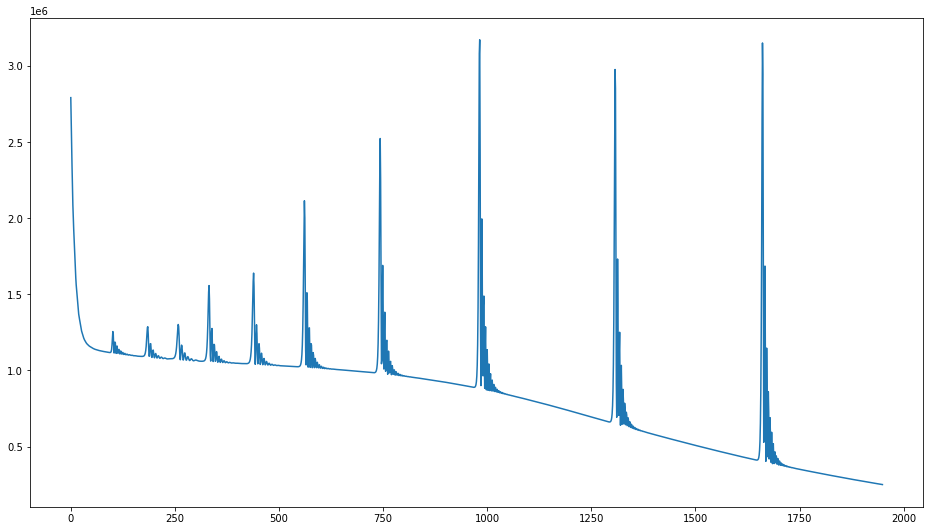

In [11]:
# Simple one-series multilayer perceptron prediction

def prepare_dataset(dataset, in_size, out_size):
    '''
    Divide input sequence into samples with 
    @in_size input size and @out_size output size
    @return two lists with samples
    '''
    in_samples = []
    out_samples = []
    
    for pos in range(0, len(dataset), training_step):
        in_end = pos + in_size
        out_end = in_end + out_size
        
        if out_end > len(dataset):
            break
        
        in_sample = dataset[pos:in_end]
        out_sample = dataset[in_end:out_end]
        
        in_samples.append(in_sample)
        out_samples.append(out_sample)
        
    return in_samples, out_samples

test_list = consumption_df['fact_value'].tolist()
test_list = test_list[:int(len(test_list) * train_data_part)]

x, y = prepare_dataset(test_list, input_size, output_size)

model = Sequential()
model.add(Dense(100, activation='relu', input_dim=input_size))
model.add(Dense(output_size))
model.compile(optimizer='adam', loss='mse')

history = model.fit(x, y, epochs=epochs_number)

# Save model
model.save('../models/10year_model')

plt.figure(figsize=(16,9))
plt.plot(history.history['loss'][50:])

RMSE predicted:  1182.1801450227092


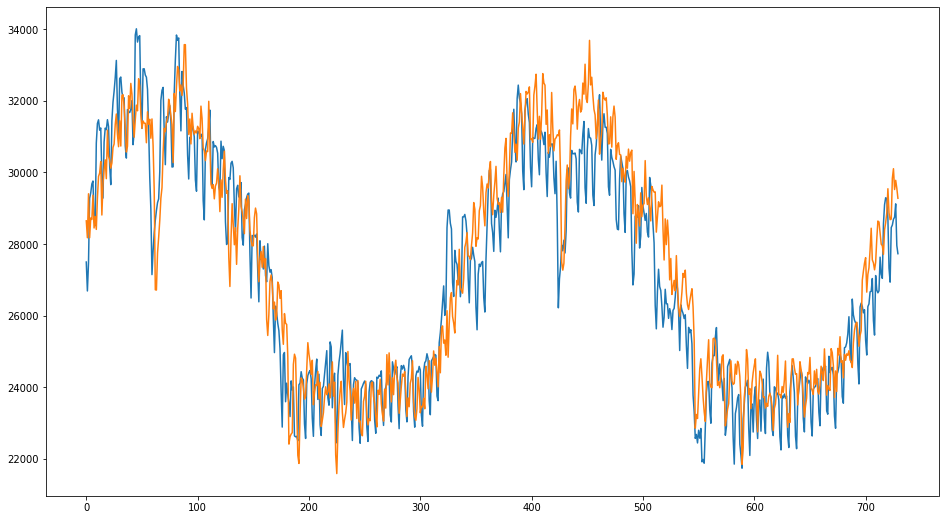

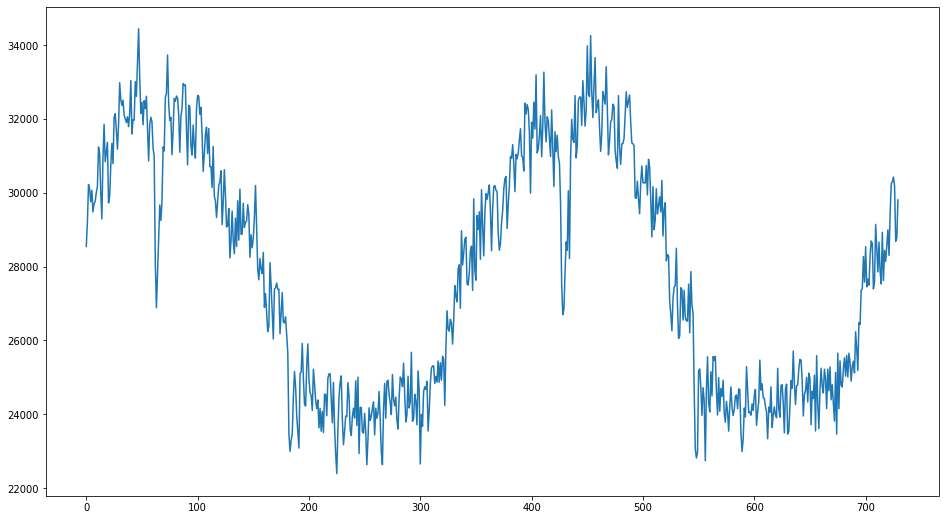

In [12]:
# One series predict
predicted_period = output_size

model = load_model('../models/10year_model')

# Test and compare to real data
input_data_start = int(len(consumption_df)*train_data_part) - input_size
input_data_end = input_data_start + input_size
predicted_df = consumption_df.iloc[input_data_start:input_data_end]
predicted_input = predicted_df['fact_value'].tolist()

model_input = array(predicted_input)
model_input = model_input.reshape((1, input_size))
model_output = model.predict(model_input, verbose=0)[0].tolist()
actual_output =  consumption_df['fact_value'].iloc[-len(model_output):].tolist()

plt.figure(figsize=(16,9))
plt.plot(actual_output)
plt.plot(model_output)

print('RMSE predicted: ', mean_squared_error(actual_output, model_output, squared=False))

# Predict new value
future_df = consumption_df.iloc[-input_size:]
future_input = future_df['fact_value'].tolist()

model_input = array(future_input)
model_input = model_input.reshape((1, input_size))
predicted_output = model.predict(model_input, verbose=0)[0].tolist()

plt.figure(figsize=(16,9))
plt.plot(predicted_output)

Epoch 1/2000
1/1 [==============================] - 0s 918us/step - loss: 442900160.0000
Epoch 2/2000
1/1 [==============================] - 0s 897us/step - loss: 388599104.0000
Epoch 3/2000
1/1 [==============================] - 0s 1ms/step - loss: 378167424.0000
Epoch 4/2000
1/1 [==============================] - 0s 2ms/step - loss: 365830912.0000
Epoch 5/2000
1/1 [==============================] - 0s 2ms/step - loss: 346839328.0000
Epoch 6/2000
1/1 [==============================] - 0s 1ms/step - loss: 322825824.0000
Epoch 7/2000
1/1 [==============================] - 0s 2ms/step - loss: 297971168.0000
Epoch 8/2000
1/1 [==============================] - 0s 2ms/step - loss: 272930048.0000
Epoch 9/2000
1/1 [==============================] - 0s 1ms/step - loss: 248087392.0000
Epoch 10/2000
1/1 [==============================] - 0s 1ms/step - loss: 223612768.0000
Epoch 11/2000
1/1 [==============================] - 0s 1ms/step - loss: 199676448.0000
Epoch 12/2000
1/1 [==================

1/1 [==============================] - 0s 2ms/step - loss: 1051904.0000
Epoch 96/2000
1/1 [==============================] - 0s 1ms/step - loss: 1050499.1250
Epoch 97/2000
1/1 [==============================] - 0s 1ms/step - loss: 1049306.6250
Epoch 98/2000
1/1 [==============================] - 0s 1ms/step - loss: 1048196.5000
Epoch 99/2000
1/1 [==============================] - 0s 1ms/step - loss: 1047085.8750
Epoch 100/2000
1/1 [==============================] - 0s 2ms/step - loss: 1046024.5000
Epoch 101/2000
1/1 [==============================] - 0s 2ms/step - loss: 1045092.3750
Epoch 102/2000
1/1 [==============================] - 0s 3ms/step - loss: 1044310.0000
Epoch 103/2000
1/1 [==============================] - 0s 2ms/step - loss: 1043622.3125
Epoch 104/2000
1/1 [==============================] - 0s 1ms/step - loss: 1042921.0000
Epoch 105/2000
1/1 [==============================] - 0s 1ms/step - loss: 1042183.6250
Epoch 106/2000
1/1 [==============================] - 0s 1ms/s

1/1 [==============================] - 0s 2ms/step - loss: 1029753.0000
Epoch 189/2000
1/1 [==============================] - 0s 1ms/step - loss: 1030494.8125
Epoch 190/2000
1/1 [==============================] - 0s 2ms/step - loss: 1032488.6875
Epoch 191/2000
1/1 [==============================] - 0s 1ms/step - loss: 1037697.6875
Epoch 192/2000
1/1 [==============================] - 0s 1ms/step - loss: 1050984.8750
Epoch 193/2000
1/1 [==============================] - 0s 1ms/step - loss: 1082711.7500
Epoch 194/2000
1/1 [==============================] - 0s 2ms/step - loss: 1146433.1250
Epoch 195/2000
1/1 [==============================] - 0s 2ms/step - loss: 1227745.0000
Epoch 196/2000
1/1 [==============================] - 0s 1ms/step - loss: 1240607.5000
Epoch 197/2000
1/1 [==============================] - 0s 1ms/step - loss: 1125256.2500
Epoch 198/2000
1/1 [==============================] - 0s 1ms/step - loss: 1029688.1250
Epoch 199/2000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 1ms/step - loss: 1022376.3750
Epoch 283/2000
1/1 [==============================] - 0s 1ms/step - loss: 1022310.1875
Epoch 284/2000
1/1 [==============================] - 0s 1ms/step - loss: 1022227.6875
Epoch 285/2000
1/1 [==============================] - 0s 1ms/step - loss: 1022133.8125
Epoch 286/2000
1/1 [==============================] - 0s 8ms/step - loss: 1022040.0000
Epoch 287/2000
1/1 [==============================] - 0s 2ms/step - loss: 1021955.1250
Epoch 288/2000
1/1 [==============================] - 0s 3ms/step - loss: 1021880.0000
Epoch 289/2000
1/1 [==============================] - 0s 3ms/step - loss: 1021809.1875
Epoch 290/2000
1/1 [==============================] - 0s 11ms/step - loss: 1021736.0000
Epoch 291/2000
1/1 [==============================] - 0s 3ms/step - loss: 1021656.3750
Epoch 292/2000
1/1 [==============================] - 0s 3ms/step - loss: 1021570.6875
Epoch 293/2000
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 1ms/step - loss: 1018845.8750
Epoch 377/2000
1/1 [==============================] - 0s 1ms/step - loss: 1016510.3750
Epoch 378/2000
1/1 [==============================] - 0s 2ms/step - loss: 1013598.3125
Epoch 379/2000
1/1 [==============================] - 0s 831us/step - loss: 1013447.6250
Epoch 380/2000
1/1 [==============================] - 0s 1ms/step - loss: 1015318.3750
Epoch 381/2000
1/1 [==============================] - 0s 975us/step - loss: 1016155.5000
Epoch 382/2000
1/1 [==============================] - 0s 934us/step - loss: 1014793.3750
Epoch 383/2000
1/1 [==============================] - 0s 1ms/step - loss: 1012948.3750
Epoch 384/2000
1/1 [==============================] - 0s 1ms/step - loss: 1012584.1250
Epoch 385/2000
1/1 [==============================] - 0s 2ms/step - loss: 1013554.6250
Epoch 386/2000
1/1 [==============================] - 0s 1ms/step - loss: 1014219.1875
Epoch 387/2000
1/1 [==============================] 

1/1 [==============================] - 0s 2ms/step - loss: 1008954.1875
Epoch 470/2000
1/1 [==============================] - 0s 2ms/step - loss: 1016164.3750
Epoch 471/2000
1/1 [==============================] - 0s 2ms/step - loss: 1029299.1875
Epoch 472/2000
1/1 [==============================] - 0s 1ms/step - loss: 1052737.7500
Epoch 473/2000
1/1 [==============================] - 0s 1ms/step - loss: 1093634.2500
Epoch 474/2000
1/1 [==============================] - 0s 2ms/step - loss: 1159726.8750
Epoch 475/2000
1/1 [==============================] - 0s 2ms/step - loss: 1254948.2500
Epoch 476/2000
1/1 [==============================] - 0s 2ms/step - loss: 1355709.1250
Epoch 477/2000
1/1 [==============================] - 0s 2ms/step - loss: 1403781.2500
Epoch 478/2000
1/1 [==============================] - 0s 1ms/step - loss: 1321586.3750
Epoch 479/2000
1/1 [==============================] - 0s 3ms/step - loss: 1142157.3750
Epoch 480/2000
1/1 [==============================] - 0s 1

Epoch 564/2000
1/1 [==============================] - 0s 1ms/step - loss: 975080.3750
Epoch 565/2000
1/1 [==============================] - 0s 1ms/step - loss: 974765.0000
Epoch 566/2000
1/1 [==============================] - 0s 2ms/step - loss: 974455.1875
Epoch 567/2000
1/1 [==============================] - 0s 1ms/step - loss: 974138.3750
Epoch 568/2000
1/1 [==============================] - 0s 1ms/step - loss: 973807.3750
Epoch 569/2000
1/1 [==============================] - 0s 2ms/step - loss: 973462.8750
Epoch 570/2000
1/1 [==============================] - 0s 2ms/step - loss: 973111.6250
Epoch 571/2000
1/1 [==============================] - 0s 2ms/step - loss: 972760.8125
Epoch 572/2000
1/1 [==============================] - 0s 1ms/step - loss: 972415.3750
Epoch 573/2000
1/1 [==============================] - 0s 2ms/step - loss: 972075.8125
Epoch 574/2000
1/1 [==============================] - 0s 1ms/step - loss: 971739.3125
Epoch 575/2000
1/1 [==============================] - 

1/1 [==============================] - 0s 930us/step - loss: 936969.1250
Epoch 659/2000
1/1 [==============================] - 0s 1ms/step - loss: 954869.8125
Epoch 660/2000
1/1 [==============================] - 0s 2ms/step - loss: 967095.3750
Epoch 661/2000
1/1 [==============================] - 0s 871us/step - loss: 955055.3750
Epoch 662/2000
1/1 [==============================] - 0s 2ms/step - loss: 936733.3750
Epoch 663/2000
1/1 [==============================] - 0s 1ms/step - loss: 935591.6250
Epoch 664/2000
1/1 [==============================] - 0s 1ms/step - loss: 947487.8750
Epoch 665/2000
1/1 [==============================] - 0s 1ms/step - loss: 951669.6250
Epoch 666/2000
1/1 [==============================] - 0s 1ms/step - loss: 941924.8750
Epoch 667/2000
1/1 [==============================] - 0s 1ms/step - loss: 931881.1250
Epoch 668/2000
1/1 [==============================] - 0s 2ms/step - loss: 933123.3125
Epoch 669/2000
1/1 [==============================] - 0s 903us/st

1/1 [==============================] - 0s 2ms/step - loss: 876715.1875
Epoch 754/2000
1/1 [==============================] - 0s 2ms/step - loss: 875984.6250
Epoch 755/2000
1/1 [==============================] - 0s 2ms/step - loss: 875252.6250
Epoch 756/2000
1/1 [==============================] - 0s 2ms/step - loss: 874519.1250
Epoch 757/2000
1/1 [==============================] - 0s 2ms/step - loss: 873783.6875
Epoch 758/2000
1/1 [==============================] - 0s 2ms/step - loss: 873046.3125
Epoch 759/2000
1/1 [==============================] - 0s 2ms/step - loss: 872306.3750
Epoch 760/2000
1/1 [==============================] - 0s 6ms/step - loss: 871564.1875
Epoch 761/2000
1/1 [==============================] - 0s 2ms/step - loss: 870819.5000
Epoch 762/2000
1/1 [==============================] - 0s 16ms/step - loss: 870072.6250
Epoch 763/2000
1/1 [==============================] - 0s 2ms/step - loss: 869323.6250
Epoch 764/2000
1/1 [==============================] - 0s 2ms/step - 

1/1 [==============================] - 0s 1ms/step - loss: 856437.0000
Epoch 849/2000
1/1 [==============================] - 0s 2ms/step - loss: 917324.3125
Epoch 850/2000
1/1 [==============================] - 0s 980us/step - loss: 862070.1875
Epoch 851/2000
1/1 [==============================] - 0s 2ms/step - loss: 797793.2500
Epoch 852/2000
1/1 [==============================] - 0s 937us/step - loss: 830191.3125
Epoch 853/2000
1/1 [==============================] - 0s 1ms/step - loss: 872936.8750
Epoch 854/2000
1/1 [==============================] - 0s 2ms/step - loss: 837535.3750
Epoch 855/2000
1/1 [==============================] - 0s 2ms/step - loss: 794077.5000
Epoch 856/2000
1/1 [==============================] - 0s 2ms/step - loss: 814341.5625
Epoch 857/2000
1/1 [==============================] - 0s 3ms/step - loss: 842304.3750
Epoch 858/2000
1/1 [==============================] - 0s 2ms/step - loss: 819452.5000
Epoch 859/2000
1/1 [==============================] - 0s 2ms/step

1/1 [==============================] - 0s 2ms/step - loss: 712643.2500
Epoch 944/2000
1/1 [==============================] - 0s 2ms/step - loss: 711708.6875
Epoch 945/2000
1/1 [==============================] - 0s 1ms/step - loss: 710777.3750
Epoch 946/2000
1/1 [==============================] - 0s 2ms/step - loss: 709844.3125
Epoch 947/2000
1/1 [==============================] - 0s 2ms/step - loss: 708907.1875
Epoch 948/2000
1/1 [==============================] - 0s 2ms/step - loss: 707969.0000
Epoch 949/2000
1/1 [==============================] - 0s 2ms/step - loss: 707033.2500
Epoch 950/2000
1/1 [==============================] - 0s 2ms/step - loss: 706099.6875
Epoch 951/2000
1/1 [==============================] - 0s 2ms/step - loss: 705165.8750
Epoch 952/2000
1/1 [==============================] - 0s 1ms/step - loss: 704229.8125
Epoch 953/2000
1/1 [==============================] - 0s 2ms/step - loss: 703292.3750
Epoch 954/2000
1/1 [==============================] - 0s 2ms/step - l

Epoch 1038/2000
1/1 [==============================] - 0s 3ms/step - loss: 624428.8750
Epoch 1039/2000
1/1 [==============================] - 0s 2ms/step - loss: 623518.0625
Epoch 1040/2000
1/1 [==============================] - 0s 2ms/step - loss: 622607.8750
Epoch 1041/2000
1/1 [==============================] - 0s 2ms/step - loss: 621698.3125
Epoch 1042/2000
1/1 [==============================] - 0s 2ms/step - loss: 620789.1875
Epoch 1043/2000
1/1 [==============================] - 0s 2ms/step - loss: 619880.8125
Epoch 1044/2000
1/1 [==============================] - 0s 1ms/step - loss: 618973.0625
Epoch 1045/2000
1/1 [==============================] - 0s 2ms/step - loss: 618065.8125
Epoch 1046/2000
1/1 [==============================] - 0s 3ms/step - loss: 617159.2500
Epoch 1047/2000
1/1 [==============================] - 0s 2ms/step - loss: 616253.3125
Epoch 1048/2000
1/1 [==============================] - 0s 2ms/step - loss: 615348.0000
Epoch 1049/2000
1/1 [======================

1/1 [==============================] - 0s 2ms/step - loss: 867978.8125
Epoch 1133/2000
1/1 [==============================] - 0s 3ms/step - loss: 890673.8125
Epoch 1134/2000
1/1 [==============================] - 0s 2ms/step - loss: 633037.5625
Epoch 1135/2000
1/1 [==============================] - 0s 2ms/step - loss: 553956.2500
Epoch 1136/2000
1/1 [==============================] - 0s 4ms/step - loss: 727883.5000
Epoch 1137/2000
1/1 [==============================] - 0s 2ms/step - loss: 768670.1250
Epoch 1138/2000
1/1 [==============================] - 0s 2ms/step - loss: 597877.4375
Epoch 1139/2000
1/1 [==============================] - 0s 2ms/step - loss: 547575.0000
Epoch 1140/2000
1/1 [==============================] - 0s 3ms/step - loss: 665621.6875
Epoch 1141/2000
1/1 [==============================] - 0s 2ms/step - loss: 677327.8750
Epoch 1142/2000
1/1 [==============================] - 0s 2ms/step - loss: 563307.4375
Epoch 1143/2000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 2ms/step - loss: 469578.3438
Epoch 1226/2000
1/1 [==============================] - 0s 3ms/step - loss: 468822.6562
Epoch 1227/2000
1/1 [==============================] - 0s 2ms/step - loss: 468082.9375
Epoch 1228/2000
1/1 [==============================] - 0s 2ms/step - loss: 467358.3438
Epoch 1229/2000
1/1 [==============================] - 0s 1ms/step - loss: 466626.1875
Epoch 1230/2000
1/1 [==============================] - 0s 2ms/step - loss: 465881.4062
Epoch 1231/2000
1/1 [==============================] - 0s 2ms/step - loss: 465140.8125
Epoch 1232/2000
1/1 [==============================] - 0s 10ms/step - loss: 464413.0625
Epoch 1233/2000
1/1 [==============================] - 0s 4ms/step - loss: 463686.7500
Epoch 1234/2000
1/1 [==============================] - 0s 4ms/step - loss: 462952.0625
Epoch 1235/2000
1/1 [==============================] - 0s 2ms/step - loss: 462215.0000
Epoch 1236/2000
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 2ms/step - loss: 403694.8750
Epoch 1320/2000
1/1 [==============================] - 0s 2ms/step - loss: 403029.4062
Epoch 1321/2000
1/1 [==============================] - 0s 5ms/step - loss: 402364.7188
Epoch 1322/2000
1/1 [==============================] - 0s 2ms/step - loss: 401700.6875
Epoch 1323/2000
1/1 [==============================] - 0s 1ms/step - loss: 401037.3125
Epoch 1324/2000
1/1 [==============================] - 0s 2ms/step - loss: 400374.5625
Epoch 1325/2000
1/1 [==============================] - 0s 2ms/step - loss: 399712.5625
Epoch 1326/2000
1/1 [==============================] - 0s 2ms/step - loss: 399051.1250
Epoch 1327/2000
1/1 [==============================] - 0s 2ms/step - loss: 398390.4062
Epoch 1328/2000
1/1 [==============================] - 0s 2ms/step - loss: 397730.3125
Epoch 1329/2000
1/1 [==============================] - 0s 955us/step - loss: 397070.9375
Epoch 1330/2000
1/1 [==============================] - 0s

Epoch 1413/2000
1/1 [==============================] - 0s 2ms/step - loss: 343832.9688
Epoch 1414/2000
1/1 [==============================] - 0s 2ms/step - loss: 343222.6875
Epoch 1415/2000
1/1 [==============================] - 0s 3ms/step - loss: 342613.1250
Epoch 1416/2000
1/1 [==============================] - 0s 4ms/step - loss: 342003.9375
Epoch 1417/2000
1/1 [==============================] - 0s 3ms/step - loss: 341395.2500
Epoch 1418/2000
1/1 [==============================] - 0s 4ms/step - loss: 340787.1875
Epoch 1419/2000
1/1 [==============================] - 0s 4ms/step - loss: 340179.5625
Epoch 1420/2000
1/1 [==============================] - 0s 5ms/step - loss: 339572.4688
Epoch 1421/2000
1/1 [==============================] - 0s 5ms/step - loss: 338965.8438
Epoch 1422/2000
1/1 [==============================] - 0s 9ms/step - loss: 338359.8125
Epoch 1423/2000
1/1 [==============================] - 0s 3ms/step - loss: 337754.2188
Epoch 1424/2000
1/1 [======================

Epoch 1507/2000
1/1 [==============================] - 0s 2ms/step - loss: 289338.1875
Epoch 1508/2000
1/1 [==============================] - 0s 2ms/step - loss: 314031.9375
Epoch 1509/2000
1/1 [==============================] - 0s 1ms/step - loss: 326268.2812
Epoch 1510/2000
1/1 [==============================] - 0s 1ms/step - loss: 300946.8125
Epoch 1511/2000
1/1 [==============================] - 0s 2ms/step - loss: 287284.9062
Epoch 1512/2000
1/1 [==============================] - 0s 2ms/step - loss: 304221.8750
Epoch 1513/2000
1/1 [==============================] - 0s 2ms/step - loss: 310822.9062
Epoch 1514/2000
1/1 [==============================] - 0s 2ms/step - loss: 293116.0000
Epoch 1515/2000
1/1 [==============================] - 0s 2ms/step - loss: 285177.5625
Epoch 1516/2000
1/1 [==============================] - 0s 2ms/step - loss: 296665.3438
Epoch 1517/2000
1/1 [==============================] - 0s 2ms/step - loss: 299746.4375
Epoch 1518/2000
1/1 [======================

1/1 [==============================] - 0s 5ms/step - loss: 239142.5469
Epoch 1602/2000
1/1 [==============================] - 0s 2ms/step - loss: 238637.4219
Epoch 1603/2000
1/1 [==============================] - 0s 5ms/step - loss: 238131.2188
Epoch 1604/2000
1/1 [==============================] - 0s 4ms/step - loss: 237624.1562
Epoch 1605/2000
1/1 [==============================] - 0s 3ms/step - loss: 237118.4062
Epoch 1606/2000
1/1 [==============================] - 0s 5ms/step - loss: 236614.5469
Epoch 1607/2000
1/1 [==============================] - 0s 5ms/step - loss: 236111.3438
Epoch 1608/2000
1/1 [==============================] - 0s 7ms/step - loss: 235607.5469
Epoch 1609/2000
1/1 [==============================] - 0s 5ms/step - loss: 235103.7031
Epoch 1610/2000
1/1 [==============================] - 0s 4ms/step - loss: 234600.9688
Epoch 1611/2000
1/1 [==============================] - 0s 4ms/step - loss: 234099.5938
Epoch 1612/2000
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 2ms/step - loss: 193931.9062
Epoch 1696/2000
1/1 [==============================] - 0s 3ms/step - loss: 193478.6094
Epoch 1697/2000
1/1 [==============================] - 0s 2ms/step - loss: 193025.9688
Epoch 1698/2000
1/1 [==============================] - 0s 2ms/step - loss: 192573.9062
Epoch 1699/2000
1/1 [==============================] - 0s 2ms/step - loss: 192122.5000
Epoch 1700/2000
1/1 [==============================] - 0s 2ms/step - loss: 191671.6562
Epoch 1701/2000
1/1 [==============================] - 0s 2ms/step - loss: 191221.4375
Epoch 1702/2000
1/1 [==============================] - 0s 3ms/step - loss: 190771.8750
Epoch 1703/2000
1/1 [==============================] - 0s 3ms/step - loss: 190322.9062
Epoch 1704/2000
1/1 [==============================] - 0s 2ms/step - loss: 189874.5000
Epoch 1705/2000
1/1 [==============================] - 0s 3ms/step - loss: 189426.8281
Epoch 1706/2000
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 3ms/step - loss: 154106.0312
Epoch 1790/2000
1/1 [==============================] - 0s 4ms/step - loss: 153713.5469
Epoch 1791/2000
1/1 [==============================] - 0s 2ms/step - loss: 153321.7188
Epoch 1792/2000
1/1 [==============================] - 0s 4ms/step - loss: 152930.6094
Epoch 1793/2000
1/1 [==============================] - 0s 4ms/step - loss: 152540.1719
Epoch 1794/2000
1/1 [==============================] - 0s 5ms/step - loss: 152150.3438
Epoch 1795/2000
1/1 [==============================] - 0s 2ms/step - loss: 151761.2812
Epoch 1796/2000
1/1 [==============================] - 0s 3ms/step - loss: 151372.8281
Epoch 1797/2000
1/1 [==============================] - 0s 2ms/step - loss: 150985.0625
Epoch 1798/2000
1/1 [==============================] - 0s 6ms/step - loss: 150598.0156
Epoch 1799/2000
1/1 [==============================] - 0s 5ms/step - loss: 150211.6094
Epoch 1800/2000
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 1ms/step - loss: 123277.9844
Epoch 1884/2000
1/1 [==============================] - 0s 4ms/step - loss: 126685.1406
Epoch 1885/2000
1/1 [==============================] - 0s 2ms/step - loss: 124327.2734
Epoch 1886/2000
1/1 [==============================] - 0s 1ms/step - loss: 120031.6719
Epoch 1887/2000
1/1 [==============================] - 0s 2ms/step - loss: 119997.0234
Epoch 1888/2000
1/1 [==============================] - 0s 1ms/step - loss: 122535.7266
Epoch 1889/2000
1/1 [==============================] - 0s 2ms/step - loss: 122267.4766
Epoch 1890/2000
1/1 [==============================] - 0s 1ms/step - loss: 119288.9219
Epoch 1891/2000
1/1 [==============================] - 0s 2ms/step - loss: 117992.6016
Epoch 1892/2000
1/1 [==============================] - 0s 3ms/step - loss: 119311.7734
Epoch 1893/2000
1/1 [==============================] - 0s 2ms/step - loss: 119939.6875
Epoch 1894/2000
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 2ms/step - loss: 92883.4062
Epoch 1978/2000
1/1 [==============================] - 0s 2ms/step - loss: 92619.2422
Epoch 1979/2000
1/1 [==============================] - 0s 2ms/step - loss: 92355.9375
Epoch 1980/2000
1/1 [==============================] - 0s 2ms/step - loss: 92093.3906
Epoch 1981/2000
1/1 [==============================] - 0s 2ms/step - loss: 91831.4141
Epoch 1982/2000
1/1 [==============================] - 0s 1ms/step - loss: 91569.8516
Epoch 1983/2000
1/1 [==============================] - 0s 2ms/step - loss: 91308.8281
Epoch 1984/2000
1/1 [==============================] - 0s 2ms/step - loss: 91048.4531
Epoch 1985/2000
1/1 [==============================] - 0s 2ms/step - loss: 90788.7969
Epoch 1986/2000
1/1 [==============================] - 0s 1ms/step - loss: 90529.8750
Epoch 1987/2000
1/1 [==============================] - 0s 1ms/step - loss: 90271.4219
Epoch 1988/2000
1/1 [==============================] - 0s 2ms/step - l

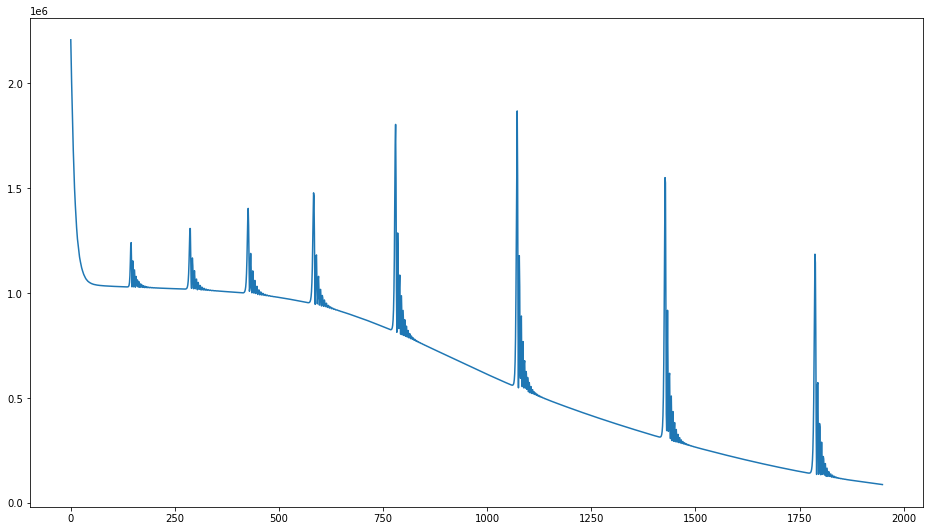

In [13]:
# Multi-series multilayer perceptron prediction

def prepare_parallel_dataset(dataset, in_size, out_size):
    '''
    Divide multiple parallel sequence into samples with
    @in_size input size and @out_size output size
    @dataset - multi-dimensional list like this [[1,2], [2,3]]
    @return two numpy arrays with samples
    '''
    in_samples = []
    out_samples = []
    
    for pos in range(0, len(dataset), training_step):
        in_end = pos + in_size
        out_end = in_end + out_size
        
        if out_end > len(dataset):
            break
        
        in_sample = dataset[pos:in_end, :]
        out_sample = dataset[in_end:out_end, :]
        
        in_samples.append(in_sample)
        out_samples.append(out_sample)
        
    return array(in_samples), array(out_samples)

def make_parallel_dataset(sequences_list, from_index, to_index):
    '''
    Concatenate parallel sequences into convinient format for model
    @sequences_list - list of parallel numpy arrays
    @from_index - make slice from from_index
    @to_index - make slice to to_index
    @return convinient numpy array
    '''
    
    for pos in range(len(sequences_list)):
        sequence = sequences_list[pos]
        sequence = sequence[from_index:to_index]
        sequence = sequence.reshape(len(sequence), 1)
        sequences_list[pos] = sequence
        
    return hstack(sequences_list)
    
# Prepare dataset
consumption_train_array = consumption_df['fact_value'].to_numpy()
volume_train_array = volumes_df['fact_value'].to_numpy()

train_data_len = int(len(consumption_train_array) * train_data_part)
parallel_dataset = make_parallel_dataset([consumption_train_array, 
                                          volume_train_array],
                                          0,
                                          train_data_len)

x, y = prepare_parallel_dataset(parallel_dataset, 
                                input_size, 
                                output_size)

# Reshape dataset for model requirements
SAMPLES_NUMBER_POS = 0
SIZE_POS = 1
PARALLEL_SEQUENCES_NUMBER_POS = 2

parallel_input_size = x.shape[SIZE_POS] * \
                      x.shape[PARALLEL_SEQUENCES_NUMBER_POS]
parallel_output_size = y.shape[SIZE_POS] * \
                       y.shape[PARALLEL_SEQUENCES_NUMBER_POS]

x = x.reshape(x.shape[SAMPLES_NUMBER_POS], parallel_input_size)
y = y.reshape(y.shape[SAMPLES_NUMBER_POS], parallel_output_size)

# Compile model
model = Sequential()
model.add(Dense(100, activation='relu', 
                input_dim=parallel_input_size))
model.add(Dense(parallel_output_size))
model.compile(optimizer='adam', loss='mse')

# Train model
history = model.fit(x, y, epochs=epochs_number)

# Save model
model.save('../models/10year_parallel_model')

plt.figure(figsize=(16,9))
plt.plot(history.history['loss'][50:])

RMSE electicity:  1382.9757320571662
RMSE volume:  1392.7861253430597


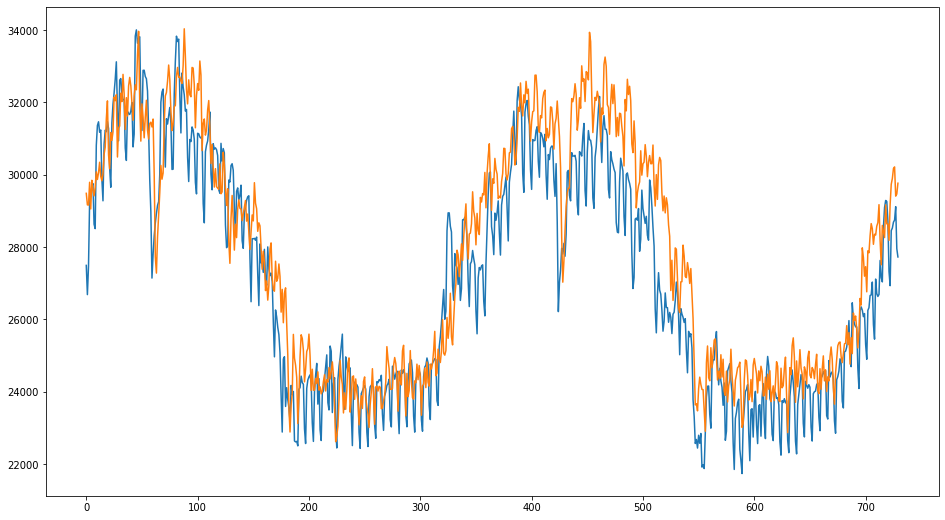

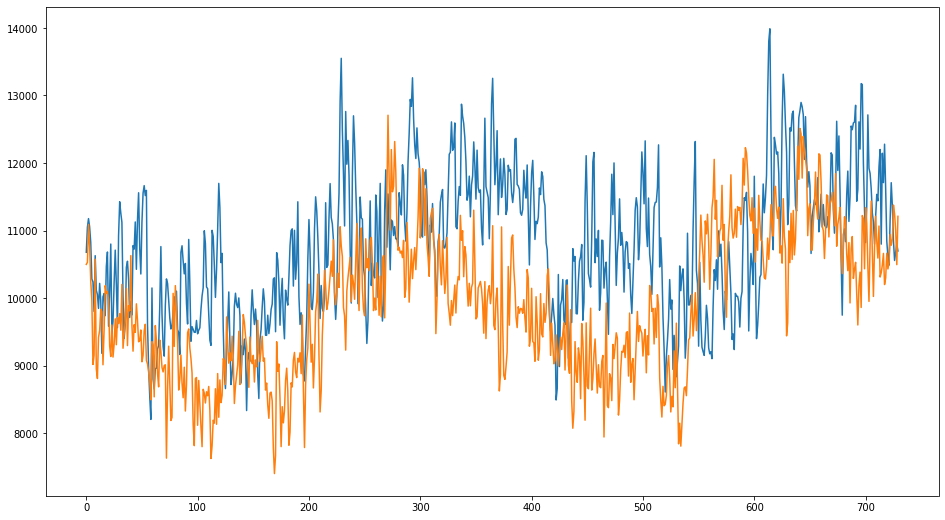

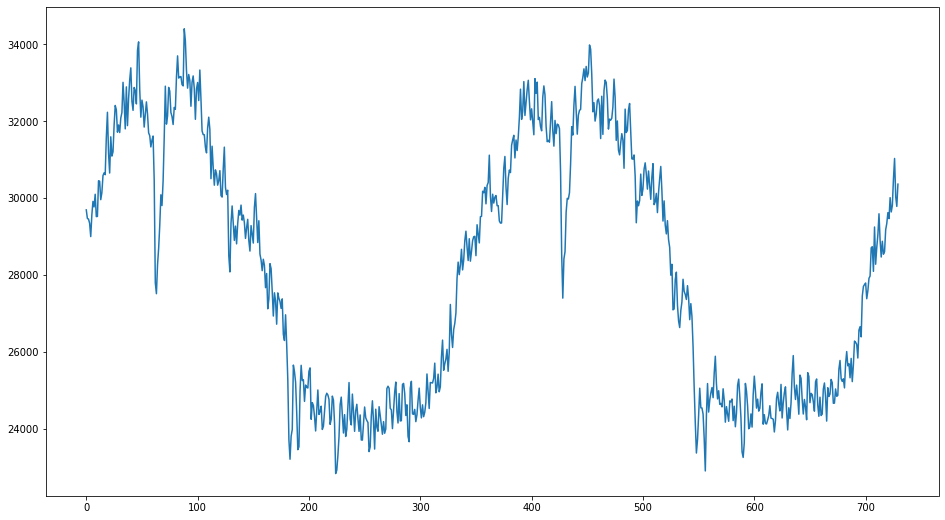

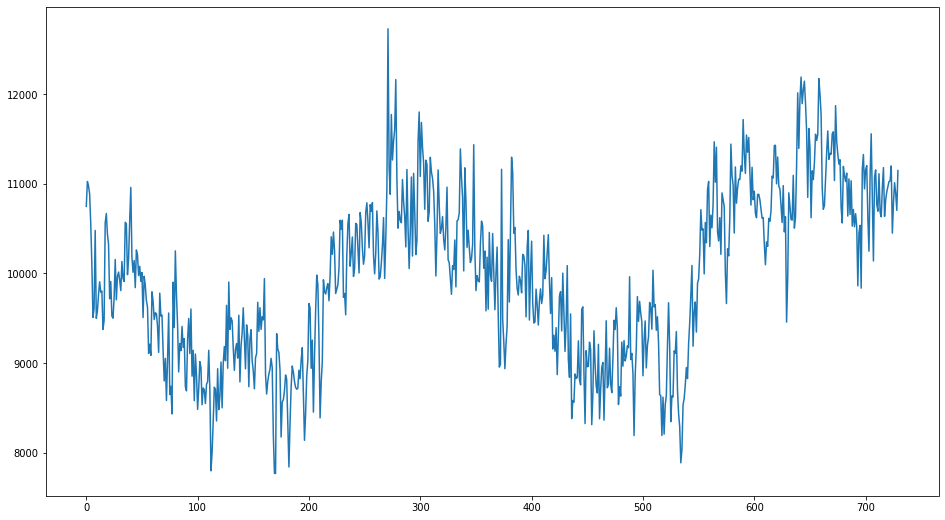

In [14]:
# Multy series predict
model = load_model('../models/10year_parallel_model')
consumption_train_array = consumption_df['fact_value'].to_numpy()

volume_train_array = volumes_df['fact_value'].to_numpy()
consumption_train_array = consumption_train_array[-(len(volume_train_array)):]

input_start = int(len(consumption_train_array)*train_data_part) - input_size
input_end = input_start + input_size
parallel_input = make_parallel_dataset([consumption_train_array, 
                                        volume_train_array],
                                        input_start,
                                        input_end)

parallel_input = parallel_input.reshape((1, parallel_input_size))
parallel_output = model.predict(parallel_input, verbose=0)

parallel_output = parallel_output[0].reshape(output_size, metrics_number).T

actual_parallel_output = consumption_train_array[-len(parallel_output[0]):]
predicted_parallel_output = parallel_output[0]

actual_volume_output = volume_train_array[-len(parallel_output[1]):]
predicted_volume_output = parallel_output[1]

plt.figure(figsize=(16,9))
plt.plot(actual_parallel_output)
plt.plot(predicted_parallel_output)

plt.figure(figsize=(16,9))
plt.plot(actual_volume_output)
plt.plot(predicted_volume_output)

print('RMSE electicity: ', mean_squared_error(actual_parallel_output, 
                                              predicted_parallel_output, 
                                              squared=False))

print('RMSE volume: ', mean_squared_error(actual_volume_output, 
                                          predicted_volume_output, 
                                          squared=False))


input_start = len(consumption_train_array) - input_size
input_end = len(consumption_train_array)
parallel_input = make_parallel_dataset([consumption_train_array, 
                                        volume_train_array],
                                        input_start,
                                        input_end)

parallel_input = parallel_input.reshape((1, parallel_input_size))
parallel_output = model.predict(parallel_input, verbose=0)

parallel_output = parallel_output[0].reshape(output_size, metrics_number).T

predicted_parallel_output = parallel_output[0]
predicted_volume_output = parallel_output[1]

plt.figure(figsize=(16,9))
plt.plot(predicted_parallel_output)

plt.figure(figsize=(16,9))
plt.plot(predicted_volume_output)


In [280]:
# Pack data for website
# This section used only for website-friendly converting 
# You shouldn't run this section

def pack_df(previous_df, predicted_list):
    '''
    Prepare data for website, add/delete some columns and rename some columns
    @previous_df - DataFrame with real data
    @predicted_list - list with predicted data
    @return formatted DataFrame with real and predicted data 
    '''
    # Reformat previous_df
    PREVIOUS_FORMAT_STR = '%d.%m.%Y %H:%M:%S'
    FORMAT_STR = '%d.%m.%Y'
    
    current_df = previous_df.copy()
    current_df = current_df.assign(predict_value=lambda zero: 0)
    
    delete_zero = lambda x: datetime.strptime(x, PREVIOUS_FORMAT_STR).strftime(FORMAT_STR)
    
    current_df['date'] = current_df['date'].apply(delete_zero)
    
    current_hour = current_df['hour'].iloc[-1]
    current_date = current_df['date'].iloc[-1]
    current_date = datetime.strptime(current_date, FORMAT_STR)
    
    additional_rows = []
    
    for value in predicted_list:
        MAX_HOUR = 24
        current_hour += compress_degree
        if current_hour >= MAX_HOUR:
            day_count = current_hour / compress_degree
            current_hour = current_hour % compress_degree
            current_date += timedelta(days=day_count)
        
        additional_rows.append({'hour': current_hour, 
                                'date': current_date.strftime(FORMAT_STR), 
                                'fact_value': 0, 
                                'predict_value': value})
    
    additional_df = pd.DataFrame(additional_rows)
    current_df = current_df.append(additional_df)
    
    # Compress data for the website
    WINDOW_LENGHT = 1
    
    average_fact_column = current_df['fact_value'] \
                          .groupby(np.arange(len(current_df))//WINDOW_LENGHT) \
                          .mean() \
                          .reset_index(drop=True)
    average_predict_column = current_df['predict_value'] \
                          .groupby(np.arange(len(current_df))//WINDOW_LENGHT) \
                          .mean() \
                          .reset_index(drop=True) 
    
    current_df = current_df.iloc[::WINDOW_LENGHT].reset_index(drop=True)
    current_df = current_df.assign(fact_value=average_fact_column)
    current_df = current_df.assign(predict_value=average_predict_column)
        
    return current_df
    
NUMBER = 3
out_file = open('../data/predicted' + str(NUMBER) + '.csv', 'w')
out_file.write(pack_df(consumption_df, predicted_output).to_csv(index=False))
out_file.close()

out_file = open('../data/predicted_parallel' + str(NUMBER) + '.csv', 'w')
out_file.write(pack_df(consumption_df, predicted_parallel_output).to_csv(index=False))
out_file.close()

out_file = open('../data/predicted_value' + str(NUMBER) + '.csv', 'w')
out_file.write(pack_df(volumes_df, predicted_volume_output).to_csv(index=False))
out_file.close()